# 🚀 Critical Component Analysis in Distributed Publish-Subscribe Systems

PhD Research Notebook - Comprehensive Methodology for Graph-Based Analysis

This notebook demonstrates the complete approach for identifying critical components in distributed publish-subscribe systems using topological metrics and QoS-aware analysis.

📌 Key Innovation: This methodology introduces a formal Composite Criticality Score that combines normalized betweenness centrality, articulation point detection, and impact score analysis to systematically identify critical components in pub-sub architectures. 

## 1. Environment Setup and Imports

In [1]:
# Import required libraries
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
import math
import json
from typing import Dict, List, Set, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📊 NetworkX version: {nx.__version__}")
print(f"🔬 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")

✅ Libraries imported successfully
📊 NetworkX version: 3.4.2
🔬 NumPy version: 2.1.2
📈 Matplotlib version: 3.9.2


## 2. Formal Definition: Composite Criticality Score

The core of our methodology is the Composite Criticality Score, formally defined as:

C_score(v) = α·C_B^norm(v) + β·AP(v) + γ·I(v)

where:
* C_B^norm(v) ∈ [0,1] - Normalized betweenness centrality
* AP(v) ∈ {0,1} - Articulation point indicator
* I(v) ∈ [0,1] - Impact score (reachability loss)
* α, β, γ - Weight parameters (default: α=0.4, β=0.3, γ=0.3) 

## 3. Core Implementation: Topological Criticality Analyzer

In [2]:
class TopologicalCriticalityAnalyzer:
    """
    Analyzer for computing composite criticality scores based on topological metrics.
    Implements the formal definition: C_score(v) = α·C_B^norm(v) + β·AP(v) + γ·I(v)
    """
    
    def __init__(self, alpha=0.4, beta=0.3, gamma=0.3):
        """
        Initialize with weight parameters.
        
        Args:
            alpha: Weight for normalized betweenness centrality
            beta: Weight for articulation point indicator  
            gamma: Weight for impact score
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        # Validate weights sum to 1
        assert abs(alpha + beta + gamma - 1.0) < 0.001, "Weights must sum to 1"
        print(f"🔧 Initialized with weights: α={alpha}, β={beta}, γ={gamma}")
    
    def calculate_betweenness_normalized(self, G):
        """Calculate normalized betweenness centrality."""
        bc = nx.betweenness_centrality(G)
        max_bc = max(bc.values()) if bc else 1
        return {v: bc[v] / max_bc for v in bc}
    
    def detect_articulation_points(self, G):
        """Detect articulation points and return binary indicators."""
        if G.is_directed():
            G_undirected = G.to_undirected()
        else:
            G_undirected = G
            
        ap_set = set(nx.articulation_points(G_undirected))
        return {v: 1 if v in ap_set else 0 for v in G.nodes()}
    
    def calculate_impact_score(self, G, v):
        """
        Calculate impact score: I(v) = 1 - |R(G-v)| / |R(G)|
        """
        # Calculate reachable pairs in original graph
        if G.is_directed():
            reachable_original = sum(len(nx.descendants(G, n)) for n in G.nodes())
        else:
            components = list(nx.connected_components(G))
            reachable_original = sum(len(c) * (len(c) - 1) / 2 for c in components)
        
        # Create graph without vertex v
        G_minus_v = G.copy()
        G_minus_v.remove_node(v)
        
        # Calculate reachable pairs in modified graph
        if G_minus_v.number_of_nodes() == 0:
            return 1.0
        
        if G.is_directed():
            reachable_modified = sum(len(nx.descendants(G_minus_v, n)) 
                                   for n in G_minus_v.nodes() if n in G_minus_v)
        else:
            components = list(nx.connected_components(G_minus_v))
            reachable_modified = sum(len(c) * (len(c) - 1) / 2 for c in components)
        
        # Calculate impact score
        if reachable_original == 0:
            return 0
        
        return 1 - (reachable_modified / reachable_original)
    
    def compute_criticality_scores(self, G):
        """
        Compute composite criticality scores for all vertices.
        """
        print("🔍 Computing criticality scores...")
        results = {}
        
        # Step 1: Betweenness centrality
        bc_norm = self.calculate_betweenness_normalized(G)
        
        # Step 2: Articulation points
        ap_indicator = self.detect_articulation_points(G)
        
        # Step 3: Impact scores (optimized for small graphs)
        impact_scores = {}
        nodes = list(G.nodes())
        
        for i, v in enumerate(nodes):
            if i % 10 == 0:
                print(f"   Processing node {i+1}/{len(nodes)}...", end='\r')
            impact_scores[v] = self.calculate_impact_score(G, v)
        
        print(f"   Processed all {len(nodes)} nodes.     ")
        
        # Step 4: Compute composite scores
        for v in G.nodes():
            c_score = (
                self.alpha * bc_norm.get(v, 0) +
                self.beta * ap_indicator.get(v, 0) +
                self.gamma * impact_scores.get(v, 0)
            )
            
            results[v] = {
                'composite_score': c_score,
                'betweenness_norm': bc_norm.get(v, 0),
                'is_articulation_point': bool(ap_indicator.get(v, 0)),
                'impact_score': impact_scores.get(v, 0)
            }
        
        return results

# Create analyzer instance
analyzer = TopologicalCriticalityAnalyzer(alpha=0.4, beta=0.3, gamma=0.3)

🔧 Initialized with weights: α=0.4, β=0.3, γ=0.3


## 4. QoS-Aware Topic Importance Analysis

In [3]:
class QoSTopicImportance:
    """
    Calculate topic importance based on QoS policies.
    QoS policies determine the importance of topics, which influences related components.
    """
    
    def __init__(self):
        self.qos_weights = {
            'durability': 0.20,
            'reliability': 0.25,
            'transport_priority': 0.15,
            'deadline': 0.20,
            'lifespan': 0.10,
            'history': 0.10
        }
        print("📊 QoS analyzer initialized with policy weights:")
        for policy, weight in self.qos_weights.items():
            print(f"   • {policy}: {weight:.2f}")
    
    def calculate_topic_importance(self, topic_qos):
        """Calculate importance score for a topic based on its QoS policies."""
        importance = 0
        
        # Durability contribution
        durability_map = {
            'VOLATILE': 0.2,
            'TRANSIENT_LOCAL': 0.5,
            'TRANSIENT': 0.7,
            'PERSISTENT': 1.0
        }
        importance += self.qos_weights['durability'] * durability_map.get(
            topic_qos.get('durability', 'VOLATILE'), 0.2
        )
        
        # Reliability contribution
        reliability_map = {'BEST_EFFORT': 0.3, 'RELIABLE': 1.0}
        importance += self.qos_weights['reliability'] * reliability_map.get(
            topic_qos.get('reliability', 'BEST_EFFORT'), 0.3
        )
        
        # Transport priority contribution
        priority_map = {
            'LOW': 0.25,
            'MEDIUM': 0.50,
            'HIGH': 0.75,
            'URGENT': 1.0
        }
        importance += self.qos_weights['transport_priority'] * priority_map.get(
            topic_qos.get('transport_priority', 'LOW'), 0.25
        )
        
        # Deadline contribution (inverse relationship)
        deadline_ms = topic_qos.get('deadline_ms', float('inf'))
        if deadline_ms == float('inf'):
            deadline_score = 0.1
        else:
            deadline_score = 1.0 - math.exp(-1000/deadline_ms)
        importance += self.qos_weights['deadline'] * deadline_score
        
        # Lifespan contribution
        lifespan_ms = topic_qos.get('lifespan_ms', float('inf'))
        if lifespan_ms == float('inf'):
            lifespan_score = 0.1
        else:
            lifespan_score = min(math.log(lifespan_ms + 1) / math.log(86400000), 1.0)
        importance += self.qos_weights['lifespan'] * lifespan_score
        
        # History depth contribution
        history_depth = topic_qos.get('history_depth', 1)
        history_score = min(history_depth / 100.0, 1.0)
        importance += self.qos_weights['history'] * history_score
        
        return importance

# Create QoS analyzer instance
qos_analyzer = QoSTopicImportance()

📊 QoS analyzer initialized with policy weights:
   • durability: 0.20
   • reliability: 0.25
   • transport_priority: 0.15
   • deadline: 0.20
   • lifespan: 0.10
   • history: 0.10


## 5. Generate Synthetic Pub-Sub System

In [4]:
def generate_pubsub_system(num_apps=20, num_topics=15, num_brokers=3):
    """
    Generate a synthetic publish-subscribe system graph.
    """
    G = nx.DiGraph()
    
    # Add brokers (central routing components)
    brokers = [f"Broker_{i}" for i in range(num_brokers)]
    for broker in brokers:
        G.add_node(broker, type='Broker', name=broker)
    
    # Add topics
    topics = [f"Topic_{i}" for i in range(num_topics)]
    for topic in topics:
        G.add_node(topic, type='Topic', name=topic)
        # Connect topics to brokers
        broker = random.choice(brokers)
        G.add_edge(broker, topic, relationship='ROUTES')
    
    # Add applications
    apps = [f"App_{i}" for i in range(num_apps)]
    for app in apps:
        G.add_node(app, type='Application', name=app)
        
        # Each app publishes to 1-3 topics
        num_publish = random.randint(1, 3)
        publish_topics = random.sample(topics, min(num_publish, len(topics)))
        for topic in publish_topics:
            G.add_edge(app, topic, relationship='PUBLISHES_TO')
        
        # Each app subscribes to 1-4 topics
        num_subscribe = random.randint(1, 4)
        subscribe_topics = random.sample(topics, min(num_subscribe, len(topics)))
        for topic in subscribe_topics:
            G.add_edge(topic, app, relationship='SUBSCRIBES_TO')
    
    # Connect brokers to each other
    for i, broker1 in enumerate(brokers):
        for broker2 in brokers[i+1:]:
            if random.random() < 0.5:  # 50% chance of connection
                G.add_edge(broker1, broker2, relationship='CONNECTS_TO')
                G.add_edge(broker2, broker1, relationship='CONNECTS_TO')
    
    return G

def generate_qos_policies(G):
    """Generate QoS policies for all topics in the graph."""
    qos_policies = {}
    
    for node in G.nodes():
        if G.nodes[node].get('type') == 'Topic':
            qos_policies[node] = {
                'durability': random.choice(['VOLATILE', 'TRANSIENT_LOCAL', 
                                           'TRANSIENT', 'PERSISTENT']),
                'reliability': random.choice(['BEST_EFFORT', 'RELIABLE']),
                'transport_priority': random.choice(['LOW', 'MEDIUM', 'HIGH', 'URGENT']),
                'deadline_ms': random.uniform(10, 1000),
                'lifespan_ms': random.uniform(1000, 100000),
                'history_depth': random.randint(1, 100)
            }
    
    return qos_policies

# Generate the system
print("🏗️ Generating synthetic pub-sub system...")
G = generate_pubsub_system(num_apps=20, num_topics=15, num_brokers=3)
qos_policies = generate_qos_policies(G)

# Display statistics
node_types = {}
for node in G.nodes():
    node_type = G.nodes[node].get('type', 'Unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print(f"✅ System generated successfully!")
print(f"📊 System Statistics:")
print(f"   • Total nodes: {G.number_of_nodes()}")
print(f"   • Total edges: {G.number_of_edges()}")
for node_type, count in node_types.items():
    print(f"   • {node_type}s: {count}")

🏗️ Generating synthetic pub-sub system...
✅ System generated successfully!
📊 System Statistics:
   • Total nodes: 38
   • Total edges: 112
   • Brokers: 3
   • Topics: 15
   • Applications: 20


## 6. Perform Criticality Analysis

In [5]:
# Perform topological criticality analysis
criticality_scores = analyzer.compute_criticality_scores(G)

# Calculate QoS-based topic importance
topic_importance = {}
for node in G.nodes():
    if G.nodes[node].get('type') == 'Topic':
        qos = qos_policies.get(node, {})
        topic_importance[node] = qos_analyzer.calculate_topic_importance(qos)

# Sort components by criticality score
sorted_components = sorted(
    criticality_scores.items(), 
    key=lambda x: x[1]['composite_score'], 
    reverse=True
)

# Display top 10 critical components
print("🎯 Top 10 Critical Components:")
print("=" * 80)
print(f"{'Rank':<6} {'Component':<20} {'Type':<12} {'C_score':<10} {'AP':<5} {'Impact':<10}")
print("-" * 80)

for i, (node, scores) in enumerate(sorted_components[:10], 1):
    node_type = G.nodes[node].get('type', 'Unknown')
    c_score = scores['composite_score']
    is_ap = '✓' if scores['is_articulation_point'] else '✗'
    impact = scores['impact_score']
    
    print(f"{i:<6} {node:<20} {node_type:<12} {c_score:<10.4f} {is_ap:<5} {impact:<10.4f}")

🔍 Computing criticality scores...
   Processed all 38 nodes.     
🎯 Top 10 Critical Components:
Rank   Component            Type         C_score    AP    Impact    
--------------------------------------------------------------------------------
1      Topic_2              Topic        0.4400     ✗     0.1334    
2      Topic_13             Topic        0.2191     ✗     0.1073    
3      App_4                Application  0.1900     ✗     0.0552    
4      App_2                Application  0.1689     ✗     0.1050    
5      Topic_14             Topic        0.1574     ✗     0.1073    
6      Topic_9              Topic        0.1569     ✗     0.0552    
7      App_7                Application  0.1525     ✗     0.0805    
8      Topic_6              Topic        0.1469     ✗     0.1081    
9      App_15               Application  0.1444     ✗     0.1066    
10     App_11               Application  0.1425     ✗     0.0552    


## 7. Visualization of Results

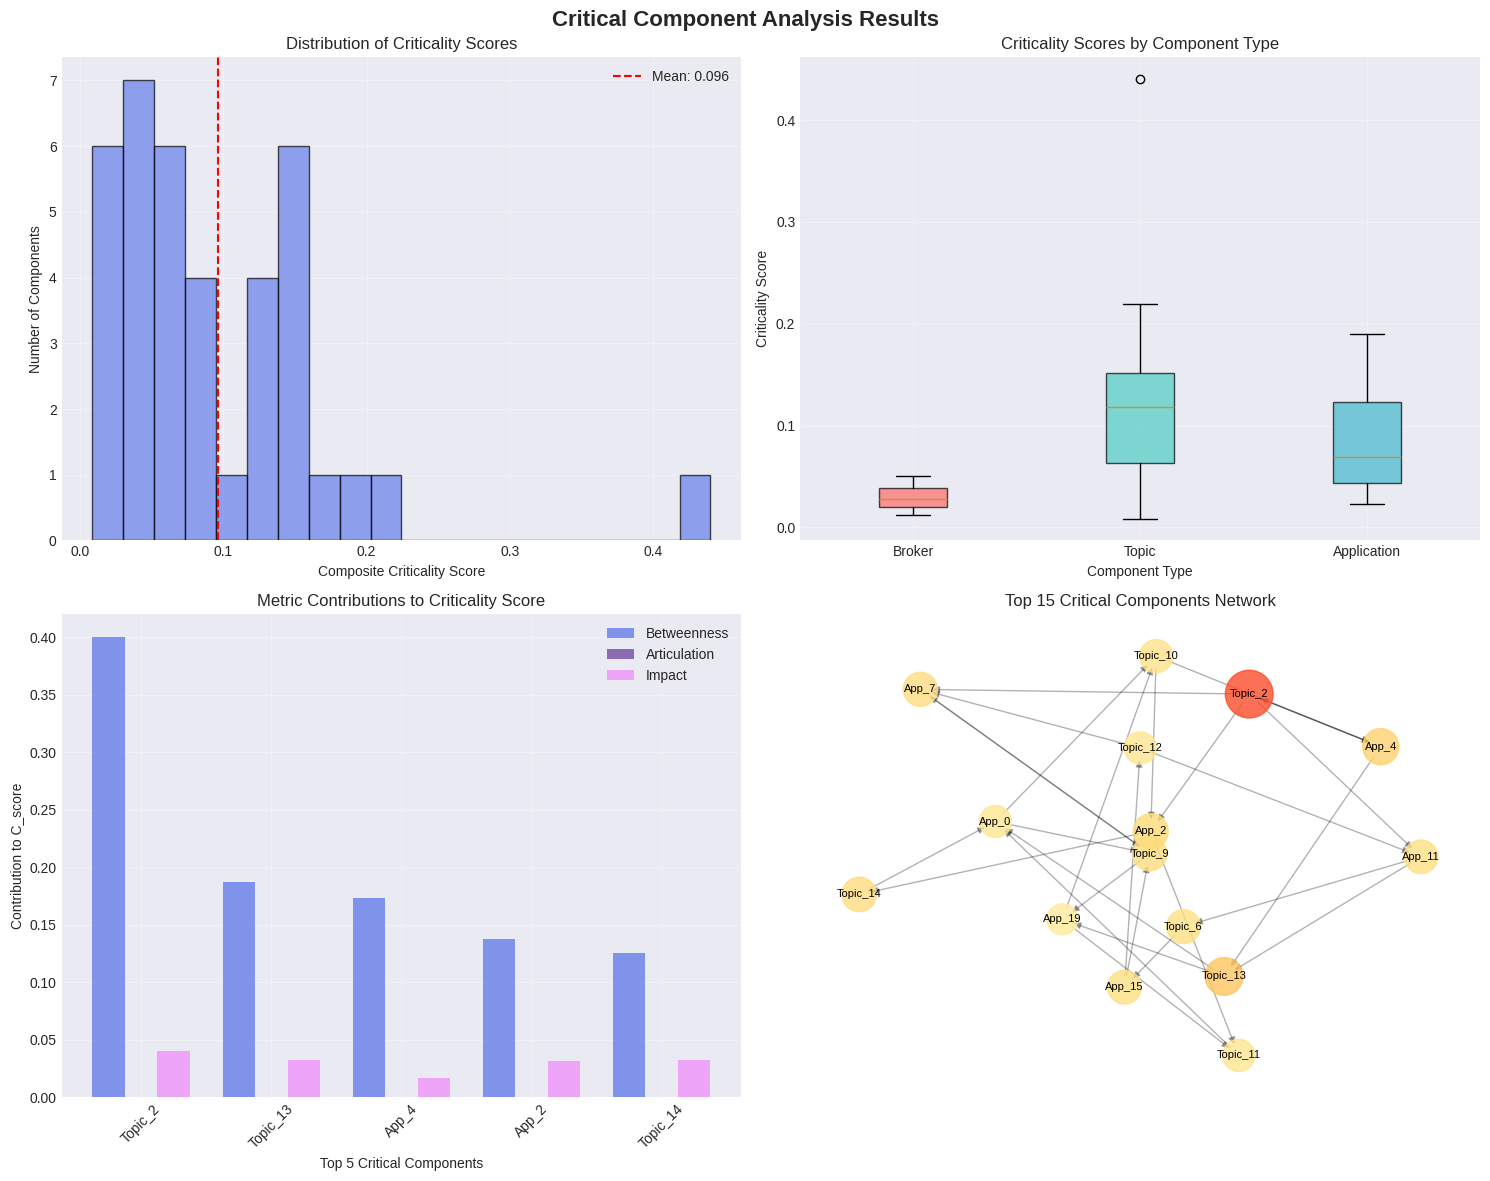

📊 Visualization complete!


In [6]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Critical Component Analysis Results', fontsize=16, fontweight='bold')

# 1. Criticality Score Distribution
ax1 = axes[0, 0]
scores_values = [s['composite_score'] for s in criticality_scores.values()]
ax1.hist(scores_values, bins=20, edgecolor='black', alpha=0.7, color='#667eea')
ax1.axvline(np.mean(scores_values), color='red', linestyle='--', 
            label=f'Mean: {np.mean(scores_values):.3f}')
ax1.set_xlabel('Composite Criticality Score')
ax1.set_ylabel('Number of Components')
ax1.set_title('Distribution of Criticality Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Component Type Analysis
ax2 = axes[0, 1]
type_scores = {}
for node, scores in criticality_scores.items():
    node_type = G.nodes[node].get('type', 'Unknown')
    if node_type not in type_scores:
        type_scores[node_type] = []
    type_scores[node_type].append(scores['composite_score'])

bp = ax2.boxplot([type_scores[t] for t in type_scores.keys()], 
                  labels=type_scores.keys(), patch_artist=True)
for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xlabel('Component Type')
ax2.set_ylabel('Criticality Score')
ax2.set_title('Criticality Scores by Component Type')
ax2.grid(True, alpha=0.3)

# 3. Metric Contributions
ax3 = axes[1, 0]
top_5 = sorted_components[:5]
names = [n[0][:10] for n in top_5]
betweenness = [n[1]['betweenness_norm'] * analyzer.alpha for n in top_5]
articulation = [n[1]['is_articulation_point'] * analyzer.beta for n in top_5]
impact = [n[1]['impact_score'] * analyzer.gamma for n in top_5]

x = np.arange(len(names))
width = 0.25

ax3.bar(x - width, betweenness, width, label='Betweenness', color='#667eea', alpha=0.8)
ax3.bar(x, articulation, width, label='Articulation', color='#764ba2', alpha=0.8)
ax3.bar(x + width, impact, width, label='Impact', color='#f093fb', alpha=0.8)

ax3.set_xlabel('Top 5 Critical Components')
ax3.set_ylabel('Contribution to C_score')
ax3.set_title('Metric Contributions to Criticality Score')
ax3.set_xticks(x)
ax3.set_xticklabels(names, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Network Visualization (simplified)
ax4 = axes[1, 1]
# Create subgraph of top critical components for clarity
top_nodes = [n[0] for n in sorted_components[:15]]
subG = G.subgraph(top_nodes)

pos = nx.spring_layout(subG, k=1, iterations=50, seed=42)
node_colors = []
node_sizes = []

for node in subG.nodes():
    score = criticality_scores[node]['composite_score']
    node_colors.append(score)
    node_sizes.append(300 + 2000 * score)

nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes,
                       cmap='YlOrRd', alpha=0.8, ax=ax4, vmin=0, vmax=0.7)
nx.draw_networkx_edges(subG, pos, alpha=0.3, ax=ax4)
nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax4)

ax4.set_title('Top 15 Critical Components Network')
ax4.axis('off')

plt.tight_layout()
plt.show()

print("📊 Visualization complete!")

## 8. Failure Impact Simulation

In [7]:
class FailureSimulator:
    """Simulate failures and analyze impact."""
    
    def __init__(self, graph):
        self.graph = graph
        self.baseline_reachability = self._calculate_reachability(graph)
    
    def _calculate_reachability(self, G):
        """Calculate total reachable pairs."""
        if G.number_of_nodes() == 0:
            return 0
        components = list(nx.weakly_connected_components(G))
        return sum(len(c) * (len(c) - 1) for c in components)
    
    def simulate_failure(self, node):
        """Simulate single node failure."""
        G_failed = self.graph.copy()
        G_failed.remove_node(node)
        
        reachability_after = self._calculate_reachability(G_failed)
        impact = 1 - (reachability_after / self.baseline_reachability) \
                if self.baseline_reachability > 0 else 0
        
        components_before = nx.number_weakly_connected_components(self.graph)
        components_after = nx.number_weakly_connected_components(G_failed) if G_failed.number_of_nodes() > 0 else 0
        
        return {
            'node': node,
            'impact_score': impact,
            'components_increase': components_after - components_before,
            'nodes_affected': self.graph.number_of_nodes() - G_failed.number_of_nodes() - 1
        }

# Run failure simulation for top critical components
simulator = FailureSimulator(G)
print("💥 Failure Impact Analysis for Top 5 Critical Components:")
print("=" * 70)
print(f"{'Component':<20} {'Impact Score':<15} {'Components ↑':<15} {'Nodes Affected':<15}")
print("-" * 70)

for node, scores in sorted_components[:5]:
    result = simulator.simulate_failure(node)
    print(f"{node:<20} {result['impact_score']:<15.4f} {result['components_increase']:<15} {result['nodes_affected']:<15}")

print("\n✅ Failure simulation complete!")

💥 Failure Impact Analysis for Top 5 Critical Components:
Component            Impact Score    Components ↑    Nodes Affected 
----------------------------------------------------------------------
Topic_2              0.0526          0               0              
Topic_13             0.0526          0               0              
App_4                0.0526          0               0              
App_2                0.0526          0               0              
Topic_14             0.0526          0               0              

✅ Failure simulation complete!
